In [1]:
from __future__ import print_function, division

#TF, Keras
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,Embedding, LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

#Pandas, Numpy
import pandas as pd
import numpy as np

#SciKit-Learn
from sklearn.model_selection import train_test_split

#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer

#Others
import os
import matplotlib.pyplot as plt
print('Tensorflow version: '+ tf.__version__)

Using TensorFlow backend.


Tensorflow version: 2.1.0


In [2]:
df_train = pd.read_csv(r"C:\Users\gabri\Downloads\archive\Corona_NLP_train.csv",
                encoding="latin1") #iso8859_2
df_test = pd.read_csv(r"C:\Users\gabri\Downloads\archive\Corona_NLP_test.csv",
                encoding="latin1") #iso8859_2

df_original = pd.concat([df_train, df_test],ignore_index=True)
df_original.shape

(44955, 6)

## Cleaning Tweets
Removed all @s and hashtags.
Also removed stop words and set the text to lower case.

In [3]:
df_original.dropna(subset=['Location','TweetAt','OriginalTweet','Sentiment'], inplace=True)

In [4]:
#fix encoding
#remove @s
#remove hashtags
def cleanTweet(s):
    stemmer = SnowballStemmer("english")
    lemmatizer = WordNetLemmatizer() 
    
    s = s.encode('ascii','ignore').decode('ascii','ignore')
    s = s.replace('#', '')
    s = s.split()
    s = [x.replace('#','') for x in s]
    s = [x for x in s if x[0] not in ['@']]
    s = [x for x in s if 'https' not in x]
    s = [x for x in s if x not in stopwords.words('english')]
    s = [stemmer.stem(x) for x in s]
    s = [lemmatizer.lemmatize(x) for x in s]
    s = ' '.join(s).lower()
    
    return s
df_original['CleanTweet'] = df_original['OriginalTweet'].apply(lambda x: cleanTweet(x))
df_original.dropna(subset=['Location','TweetAt','OriginalTweet','CleanTweet','Sentiment'], inplace=True)
df = df_original.copy()

In [5]:
#Save DataFrame to local file
df.to_parquet('df_covid.parquet.gzip',
              compression='gzip')  

#Read Saved DataFrame
#df = pd.read_parquet('df_covid.parquet.gzip') 

In [9]:
series_f, unique = df['Sentiment'].factorize()
df['Sentiment_id'] = series_f
print(f"Vocab: {unique.tolist()}")

Vocab: ['Neutral', 'Positive', 'Negative', 'Extremely Positive', 'Extremely Negative']


In [10]:
# Set the vocabulary size
vocabulary_size = 50000

tokenizer = Tokenizer(num_words=vocabulary_size+1, lower= True, oov_token="<OOV>")
tokenizer.fit_on_texts(df.CleanTweet)

sequences = tokenizer.texts_to_sequences(df.CleanTweet)

# Load in training and test data (note the difference in convention compared to scikit-learn)
X_train, X_test, y_train, y_test = train_test_split(
    sequences, df.Sentiment_id, test_size=0.2, random_state=42)

In [11]:
# TODO: Pad sequences in X_train and X_test
max_words = 100

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [12]:
# Transform our y-list with categories into shape (x, n-categories)
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

# TODO: Design your model
embedding_size = 64
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           6400000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 6,466,505
Trainable params: 6,466,505
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']
             )

In [15]:
batch_size = 64
num_epochs = 2

X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]  # rest for training

history = model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=0,min_delta=0.0001)])

C:\Users\gabri\Anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 28360 samples, validate on 64 samples
Epoch 1/2
28360/28360 [==============================] - 123s 4ms/step - loss: 1.2216 - accuracy: 0.4806 - val_loss: 1.0034 - val_accuracy: 0.5781
Epoch 2/2
28360/28360 [==============================] - 135s 5ms/step - loss: 0.7342 - accuracy: 0.7215 - val_loss: 0.8873 - val_accuracy: 0.6875


In [16]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(model_file)

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

In [17]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(scores[0],scores[1]))

Test set
  Loss: 0.845
  Accuracy: 0.680


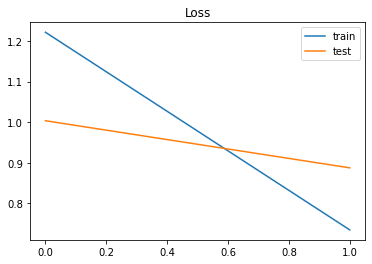

In [18]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

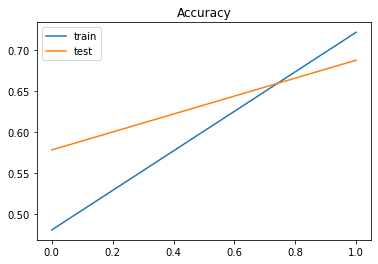

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();